In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0 #speed of light in m/s and vacuum permitivity in units of F/m 

### Propagation through Crystal

In [18]:
## SHG calculation
def CoupledAmplitude_SHG(P1_avg_0 = 1e-6, P2_avg_0 = 1e-6, phi1_0 = np.pi/2, phi2_0 = -np.pi/2, 
                     lam1 = 1.064e-6, n1 =2.1 , n2=2.1, d_eff = (20e-12)*(2/np.pi), 
                     T_p = 30e-12, R_p =  1e3, L= 10e-3, N_z = 1000):
    """ 
    Parameters:
    phi1_0[float]   : phase of the input FH beam
    phi2_0[float]   : phase of the input SH beam
    lam1[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    P1_avg_0[float] : input average FH power for the pulsed input in units of W
    P2_avg_0[float] : input average SH power for the pulsed input in units of W
    T_p[float]      : pulse width for the FH and the SH pulses in units of s
    R_p[float]      : repetition rate in units of 1/s
    N_z[int]        : number of sampling points
    
    Returns:
    I1,I2,P1,P2, P1_avg, P2_avg
    """
    # Parmeters from input
    P1_0     = P1_avg_0/(T_p*R_p) #input peak power for the FH [W]
    P2_0     = P2_avg_0/(T_p*R_p) #input peak power for the SH [W]
    P_FH_0   = P1_avg_0/R_p #input FH pulse energy [J=Ws]  (not used in calculation)
    P_SH_0   = P2_avg_0/R_p #input SH pulse energy [J=Ws] (not used in calculation)
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    
    #S_eff=(1e-6)**2 or use the Rayleigh length z_0 of a Gaussian beam, assuming that the crystal
    #length L=2*z_0=2*np.pi*(w_0**2)/(lam1/n1) where w_0 is the waist radius of the Gaussian beam 
    #which gives w_0=sqrt((L*(lam1/n1))/(2*np.pi)), the beam radius at the Rayleigh length is sqrt(2)*w_0
    w_0   = np.sqrt((L*(lam1/n1))/(2*np.pi)) #waist radius of the Gaussian beam
    S_eff = np.pi*(np.sqrt(2)*w_0)**2 #effective area of the collimated beam in the crystal in units of m**2
    
    # Prefactor in cooupled amplitude equation
    Q1     = 2*(omega1**2)*d_eff/(k1*(c**2)) 
    Q2     = (omega2**2)*d_eff/(k2*(c**2))  
    
    
    # Create grid
    dz    = L/(N_z-1)
    L_    = np.linspace(0,L, N_z)
    A1    = np.zeros(N_z, dtype = np.complex128)
    A2    = np.zeros(N_z, dtype = np.complex128)
    A1[0] = np.sqrt(P1_0/(2*n1*c*epsilon_0*S_eff))*np.exp(-1j*phi1_0) 
    A2[0] = np.sqrt(P2_0/(2*n2*c*epsilon_0*S_eff))*np.exp(-1j*phi2_0) 
    
    '''
    # Attention I is Equal the Power of BOTH Beams
    I1_0  = P1_0/S_eff
    I2_0  = P2_0/S_eff
    I     = I1_0 + I2_0
    '''
    
    #Phase Missmatch
    del_kz = 2*k1-k2 
    
    # Compute Coupled Amplitudes evolution along L in crystal (Boyd: 2.6.10,2.6.11)
    for i in range(1,N_z):
        A1[i] = A1[i-1]+(1j*Q1*A2[i-1]*np.conjugate(A1[i-1])*dz)*np.exp(-1j*del_kz*L_[i-1])
        A2[i] = A2[i-1]+(1j*Q2*(A1[i-1]**2)*dz)*np.exp(1j*del_kz*L_[i-1])

    # Compute final Results
    I1     = 2*n1*c*epsilon_0*(np.abs(A1)**2) #FH Poynting vector in units of W/m**2
    I2     = 2*n2*c*epsilon_0*(np.abs(A2)**2) #SH Poynting vector in units of W/m**2
    
    P1     = I1*S_eff #FH peak power in units of W
    P2     = I2*S_eff #FH peak power in units of W
    P1_avg = P1*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    P2_avg = P2*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    
    return L_, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg

In [19]:
# Test Function for standard Parameters
L, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg = CoupledAmplitude_SHG(N_z=1000, L=300e-3)

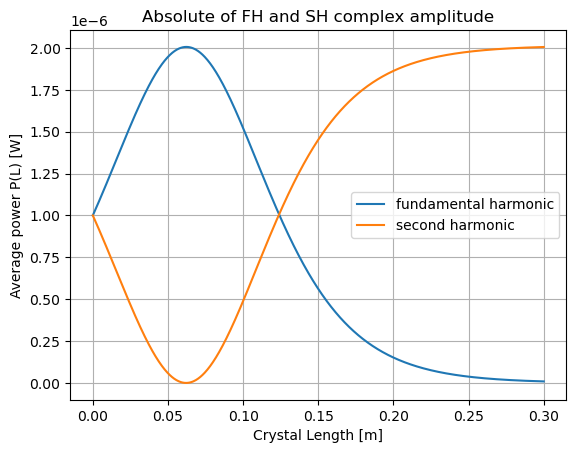

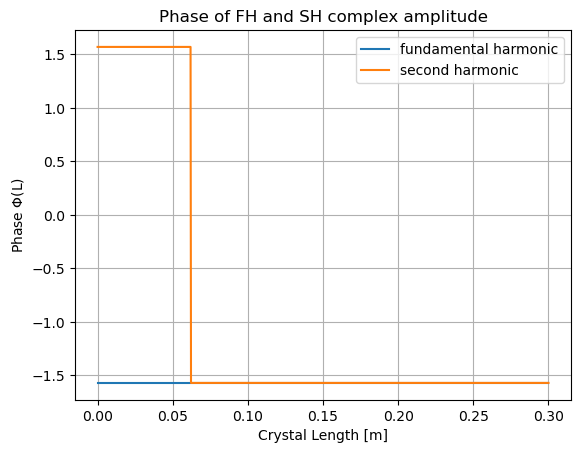

In [20]:
## Display results ###
#Amplitude
plt.figure()
plt.title("Absolute of FH and SH complex amplitude")
plt.plot(L, P1_avg , label = "fundamental harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(L, P2_avg , label = "second harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Crystal Length [m]")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.title("Phase of FH and SH complex amplitude")
plt.plot(L, np.angle(A1) , label = "fundamental harmonic")
plt.plot(L, np.angle(A2) , label = "second harmonic")
plt.xlabel("Crystal Length [m]")
plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()


### Analysis of Crystal Output for several Input Parameters ###

Now I want to compute the output of the crystal at the end for various compinations of second harmonic input phases and amplitudes, the fundamental mode shall be fixed

In [305]:
import time


#FIRST LETS DO AN ANALYSIS AS IN THE REFERENCE PAPER
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)

#Construct List of Starting Values for evaluation
nP,nPhi = (50,2)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(-np.pi/2, np.pi/2, nPhi)

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi), dtype = np.complex128)
A2 = np.zeros((nP, nPhi), dtype = np.complex128)
P1 = np.zeros((nP, nPhi))
P2 = np.zeros((nP, nPhi))
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P2_avg_0 = P2_avg_0, phi2_0 = phi2_0)
        A1[i,j] = A1_[-1] 
        A2[i,j] = A2_[-1]
        P1[i,j] = P1_avg_[-1] 
        P2[i,j] = P2_avg_[-1]
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))



Processing Time: 0.4996035099029541
Time per Iteration: 0.004996035099029541


Results for SH_phase ( 0.5 pi)


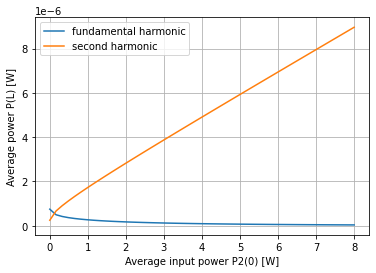

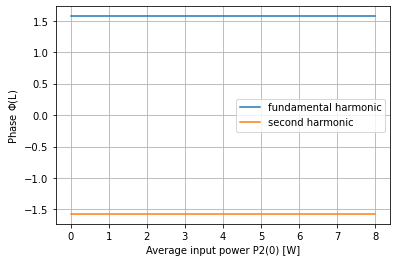

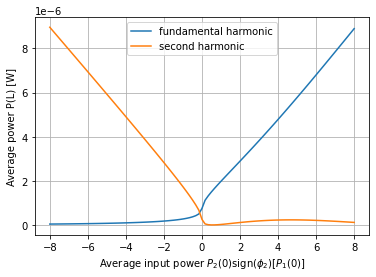

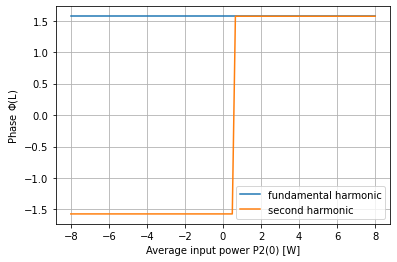

In [310]:
## Display results ###

# As an Example look at the output of the SH as a function of fixed input SH phase
x  = P2_avg_0_array/P1_avg_0
print("Results for SH_phase (", phi2_0_array[1]/np.pi, "pi)")
ind = 0

#Amplitude
plt.figure()
plt.plot(x, P1[:,ind] , label = "fundamental harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P2[:,ind] , label = "second harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.plot(x, np.angle(A1[:,ind]) , label = "fundamental harmonic")
plt.plot(x, np.angle(A2[:,ind]) , label = "second harmonic")
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()

#Reconstruct that Plot as shown in Paper
x  = np.concatenate((np.sign(phi2_0_array[0])*np.flip(P2_avg_0_array),np.sign(phi2_0_array[1])*P2_avg_0_array))/P1_avg_0

#Amplitude
y1 = np.concatenate((np.flip(P1[:,0]),P1[:,1]))
y2 = np.concatenate((np.flip(P2[:,0]),P2[:,1]))
plt.figure()
plt.plot(x, y1 , label = "fundamental harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, y2 , label = "second harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Average input power " + r"$P_2(0)$sign$(\phi_2)$"   + r"[$P_1(0)$]")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

#Phase
y1 = np.concatenate((np.flip(A1[:,0]),A1[:,1]))
y2 = np.concatenate((np.flip(A2[:,0]),A2[:,1]))
plt.figure()
plt.plot(x, np.angle(y1) , label = "fundamental harmonic")
plt.plot(x, np.angle(y2) , label = "second harmonic")
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()



### Recreate plot from paper

In [199]:
L, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg_, P2_avg_ =   CoupledAmplitude_SHG(P1_avg_0 = 2*1e-6, P2_avg_0 = 2*1e-6)
L, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg =   CoupledAmplitude_SHG(P1_avg_0 = 1e-6, P2_avg_0 = 1e-6)
print(P2_avg[-1]/P2_avg_[-1])

0.11450233933012188


### Vary FH-power and Phase

In [358]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 2
P1_avg_0_array = np.linspace(0,8*1e-6,nP)
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)
phi1_0_array   = [-np.pi, -3*np.pi/4, -np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi ]

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
A2 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
P1 = np.zeros((nP, nPhi, len(phi1_0_array )))
P2 = np.zeros((nP, nPhi, len(phi1_0_array )))
for i,P1_avg_0 in enumerate(P1_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        for k,phi1_0 in enumerate(phi1_0_array): 
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P1_avg_0 = P1_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j,k] = A1_[-1] 
            A2[i,j,k] = A2_[-1]
            P1[i,j,k] = P1_avg_[-1] 
            P2[i,j,k] = P2_avg_[-1]
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

Processing Time: 4.520662307739258
Time per Iteration: 0.04520662307739258


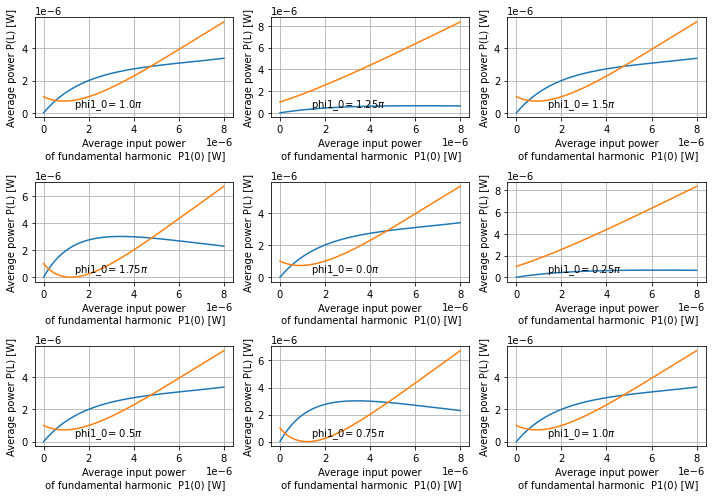

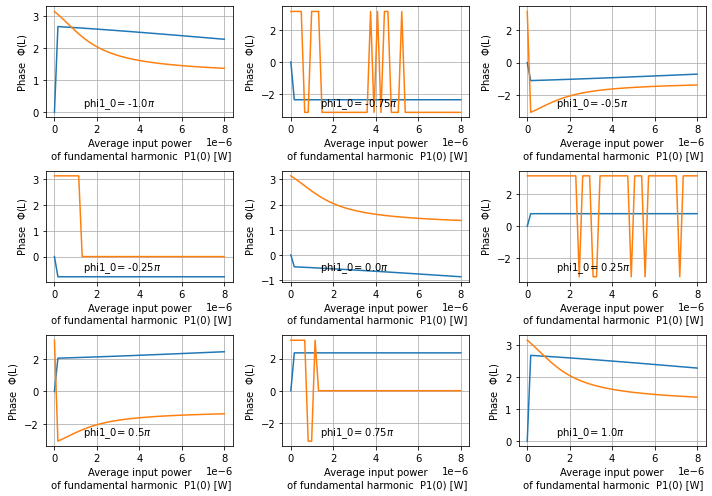

In [359]:
## Display results ###
# Here I choose one phase input for the second harmonic and plot the output for different FH input strength
x  = P1_avg_0_array

#Amplitude

fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,1,k])
    y2 = np.squeeze(P2[:,1,k])
    axs[k].annotate("phi1_0= "+ str((phi1_0)%(2*phi2_0_array[1])/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(A1[:,1,k]) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(A2[:,1,k]) , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Phase  " + r"$\Phi$"+ "(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

In [362]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 2
P1_avg_0_array = np.linspace(0,8*1e-6,nP)
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)
phi1_0_array   = [-np.pi, -3*np.pi/4, -np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi ]

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
A2 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
P1 = np.zeros((nP, nPhi, len(phi1_0_array )))
P2 = np.zeros((nP, nPhi, len(phi1_0_array )))
for i,P1_avg_0 in enumerate(P1_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        for k,phi1_0 in enumerate(phi1_0_array): 
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P1_avg_0 = P1_avg_0, phi1_0 = phi2_0, phi2_0 = phi1_0)
            A1[i,j,k] = A1_[-1] 
            A2[i,j,k] = A2_[-1]
            P1[i,j,k] = P1_avg_[-1] 
            P2[i,j,k] = P2_avg_[-1]
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

Processing Time: 4.468476057052612
Time per Iteration: 0.04468476057052612


<ipython-input-367-0ba148a975e2>:12: RuntimeWarning: invalid value encountered in double_scalars
  axs[k].annotate("phi1_0= "+ str(((2*phi2_0_array[1])%np.abs(phi1_0))/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction')


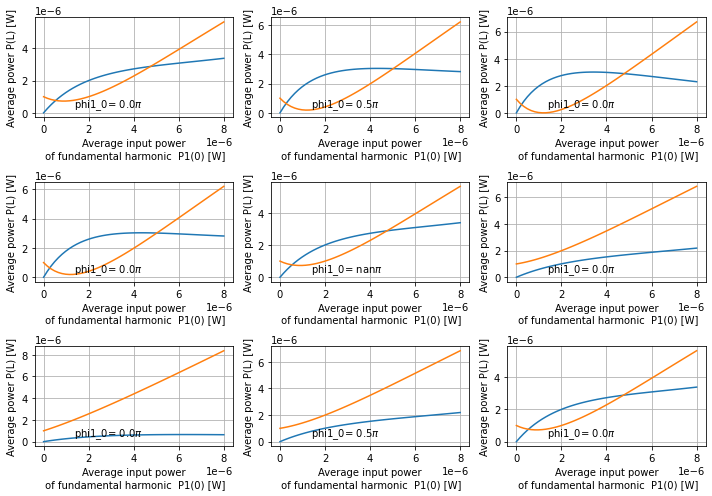

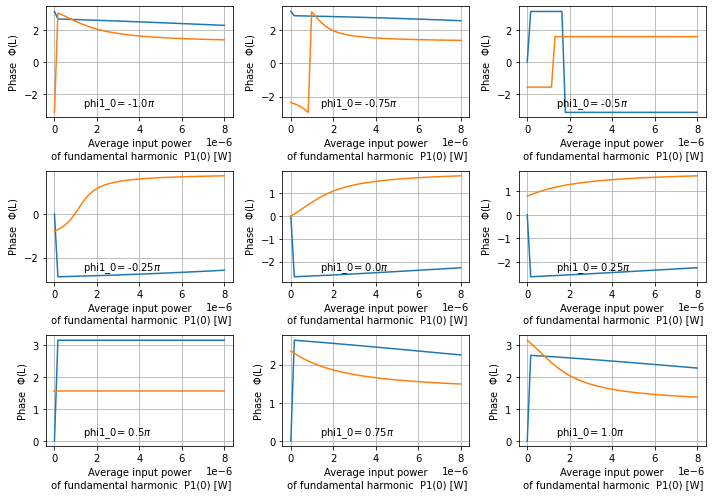

In [367]:


## Display results ###
# Here I choose one phase input for the second harmonic and plot the output for different FH input strength
x  = P1_avg_0_array

#Amplitude

fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,1,k])
    y2 = np.squeeze(P2[:,1,k])
    axs[k].annotate("phi1_0= "+ str(((phi2_0_array[1])%np.abs(phi1_0))/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(A1[:,1,k]) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(A2[:,1,k]) , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Phase  " + r"$\Phi$"+ "(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()





###  Vary SH input Phase and Amplitude for otherwise fixed parameters

In [269]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 21
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)
phi1_0_array   = [-np.pi, -3*np.pi/4, -np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi ]

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
A2 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
P1 = np.zeros((nP, nPhi, len(phi1_0_array )))
P2 = np.zeros((nP, nPhi, len(phi1_0_array )))
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        for k,phi1_0 in enumerate(phi1_0_array): 
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_= CoupledAmplitude_SHG(P1_avg_0 = P1_avg_0, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j,k] = A1_[-1] 
            A2[i,j,k] = A2_[-1]
            P1[i,j,k] = P1_avg_[-1] 
            P2[i,j,k] = P2_avg_[-1]
            
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

Processing Time: 46.93128204345703
Time per Iteration: 0.0446964590890067


EXAMPLE for phi2=
0.0


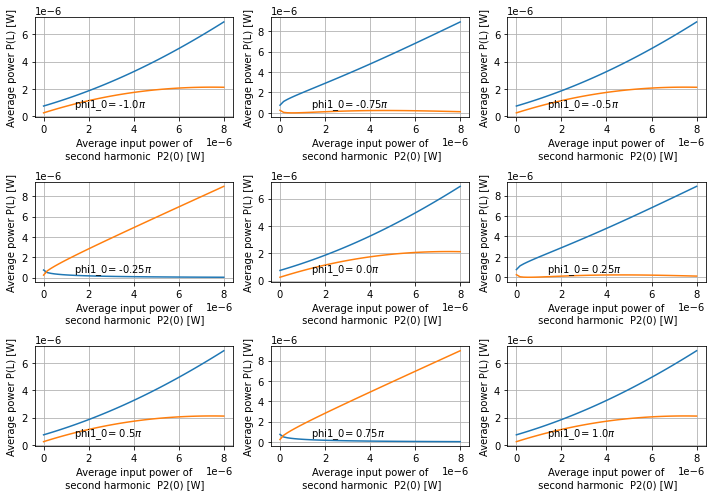

EXAMPLE for phi2=
-1.0


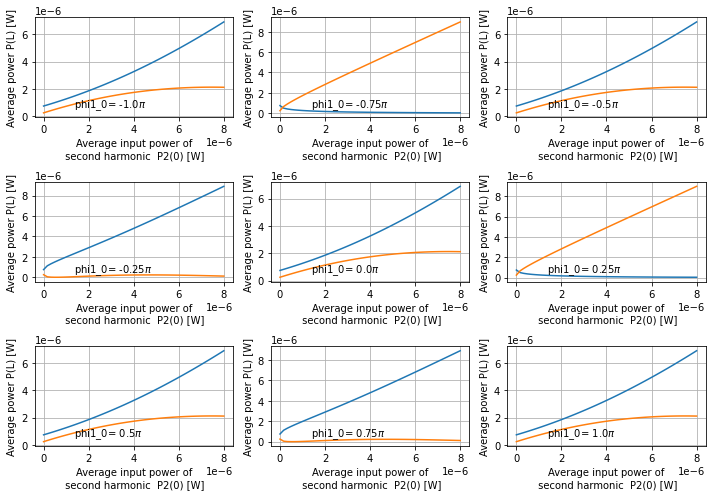

EXAMPLE for phi2=
-0.5


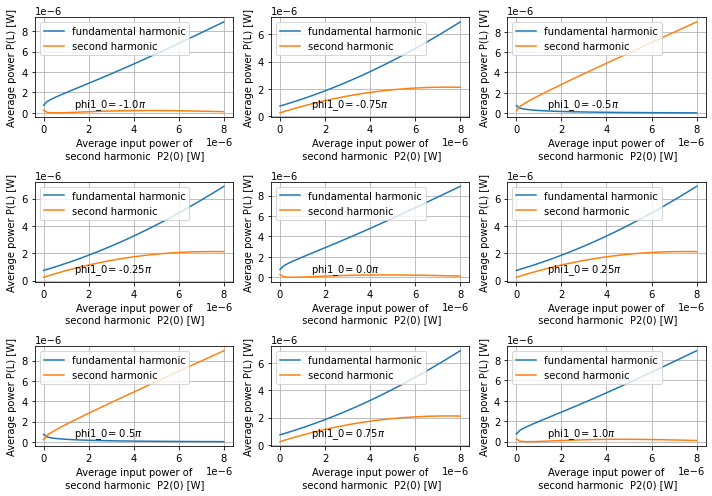

For the output the ratio of phi2 to phi1 is relevant or their difference... So By changing phi2 I can acess all values I could as when i would change phi1


In [270]:
## Display results ###
# Here I choose one phase input for the second harmonic and plot the output for different FH input strength
x  = P2_avg_0_array

ind = int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()'''

ind = 0#int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
#plt.legend()
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()
'''
ind = 5#int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()
'''

print("For the output the ratio of phi2 to phi1 is relevant or their difference... So By changing phi2 I can acess all values I could as when i would change phi1")

In [271]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 41
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(0, np.pi, nPhi)

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi), dtype = np.complex128)
A2 = np.zeros((nP, nPhi), dtype = np.complex128)
P1 = np.zeros((nP, nPhi))
P2 = np.zeros((nP, nPhi))
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg= CoupledAmplitude_SHG(P1_avg_0 = 1e-6, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j] = A1_[-1] 
            A2[i,j] = A2_[-1]
            P1[i,j] = P1_avg_[-1] 
            P2[i,j] = P2_avg_[-1]
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

Processing Time: 10.268344402313232
Time per Iteration: 0.0050089484889332845


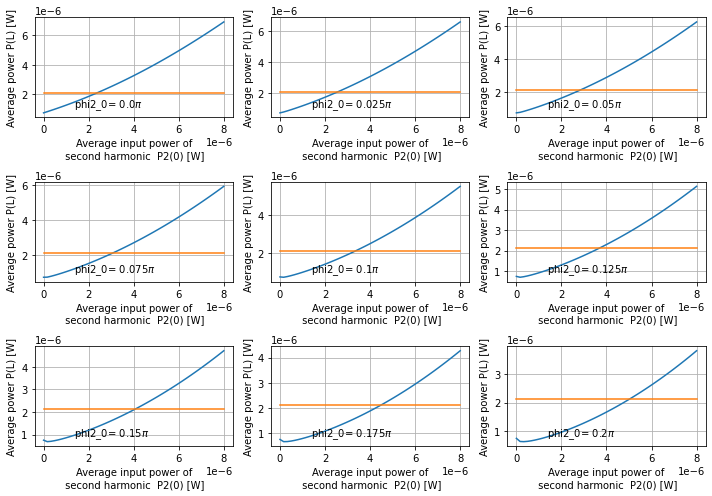

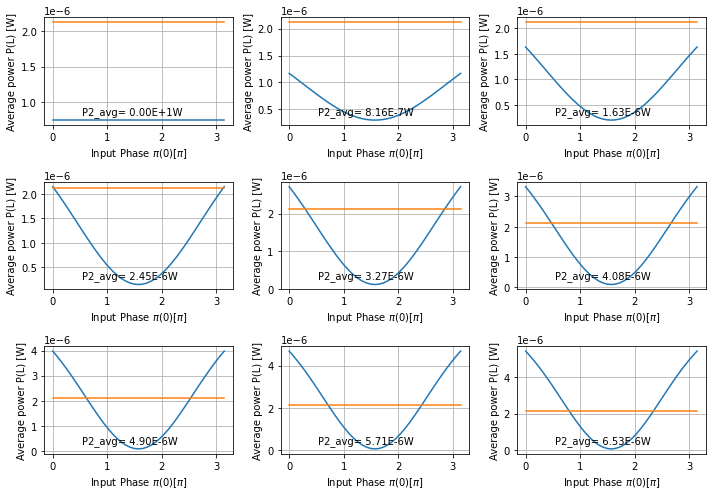

In [272]:
#Amplitude
x = P2_avg_0_array 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi2_0 in enumerate(phi2_0_array): 
    if k ==9:
        break
    y1 = np.squeeze(P1[:,k])
    y2 = np.squeeze(P2[:,k])
    axs[k].annotate("phi2_0= "+ str(phi2_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Amplitude
from decimal import Decimal
#f"{Decimal('40800000000.00000000000000'):.2E}"
x = phi2_0_array
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,P2_avg_0 in enumerate(P2_avg_0_array): 
    if k ==9:
        break
    val = P2_avg_0_array[k*5]
    y1 = np.squeeze(P1[k*5,:])
    y2 = np.squeeze(P2[k*5,:])
    axs[k].annotate("P2_avg= "+ "{:.2E}".format(Decimal(str(val))) +"W", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_ylabel("Average power P(L) [W]")
    axs[k].set_xlabel("Input Phase " + r"$\pi$" + "(0)" + "[" + r"$\pi$" + "]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

In [377]:
np.linspace(0.1*P1_avg_0, 1.1*P1_avg_0, 11)

array([1.0e-07, 2.0e-07, 3.0e-07, 4.0e-07, 5.0e-07, 6.0e-07, 7.0e-07,
       8.0e-07, 9.0e-07, 1.0e-06, 1.1e-06])

1e-08
Processing Time: 10.347408056259155
Time per Iteration: 0.005047516125004466
Fundamental Mode


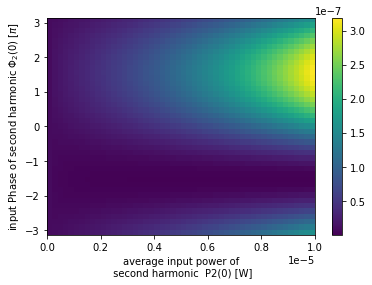

Second Harmonic


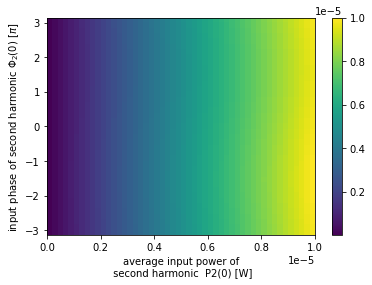

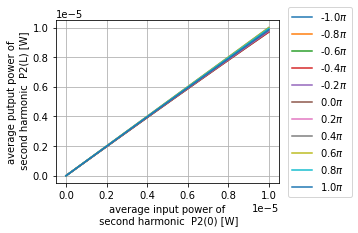

3.3733333333333334e-06
Processing Time: 10.427726745605469
Time per Iteration: 0.0050866959734660825
Fundamental Mode


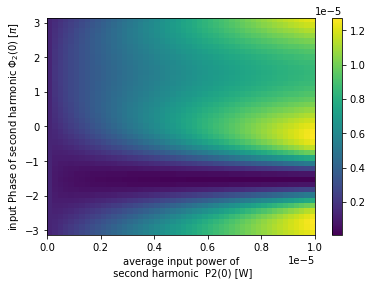

Second Harmonic


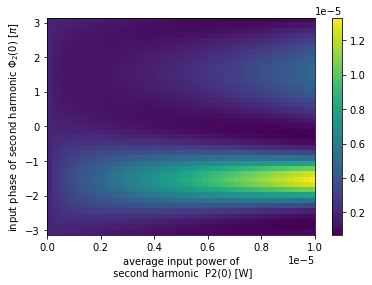

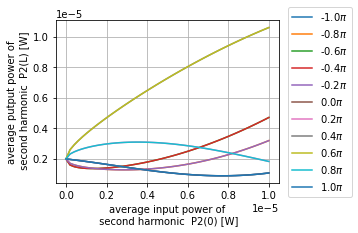

6.736666666666667e-06
Processing Time: 10.455472707748413
Time per Iteration: 0.005100230589145567
Fundamental Mode


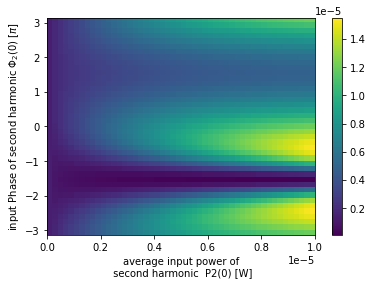

Second Harmonic


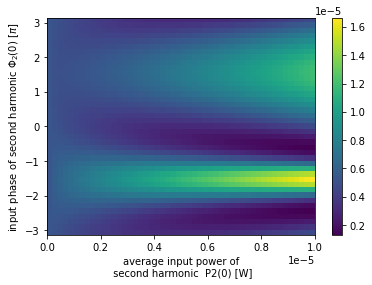

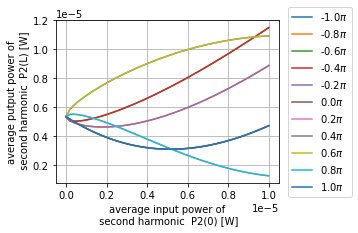

1.01e-05
Processing Time: 10.410776138305664
Time per Iteration: 0.005078427384539348
Fundamental Mode


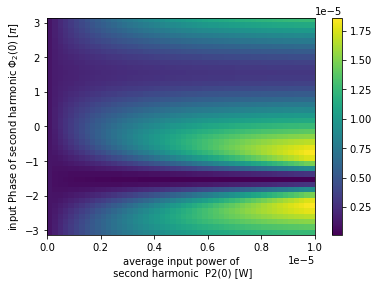

Second Harmonic


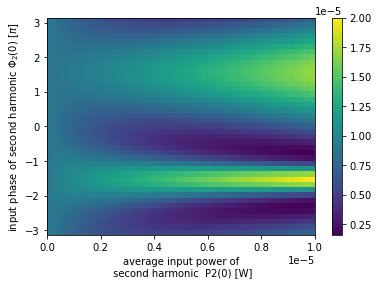

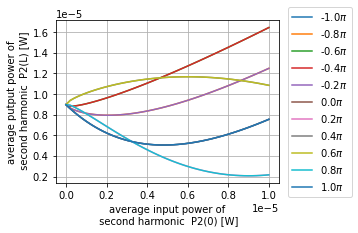

In [397]:
# Now I want to create a reasonable 2D plot

#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 41
P1_avg_0_ = 1e-6
for P1_avg_0 in np.linspace(0.01*P1_avg_0_, 10.1*P1_avg_0_, 4):
    print(P1_avg_0)
    P2_avg_min, P2_avg_max = (0,10*P1_avg_0_)
    P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
    phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)

    start = time.time()
    P1 = np.zeros((nP, nPhi))
    P2 = np.zeros((nP, nPhi))
    A1 = np.zeros((nP, nPhi), dtype = np.complex128)
    A2 = np.zeros((nP, nPhi), dtype = np.complex128)
    for i,P2_avg_0 in enumerate(P2_avg_0_array):
        for j,phi2_0 in enumerate(phi2_0_array):
                L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P1_avg_0 =P1_avg_0, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0)
                A1[i,j] = A1_[-1] 
                A2[i,j] = A2_[-1]
                P1[i,j] = P1_avg_[-1] 
                P2[i,j] = P2_avg_[-1]

    end = time.time()
    print("Processing Time:", end - start)
    print("Time per Iteration:", (end - start)/(nP*nPhi))

    #Array for saved Values
    y1 = np.flip(P1.T, axis=0)
    y2 = np.flip(P2.T, axis=0)
    #Fundamental Mode
    print("Fundamental Mode")
    fig, ax = plt.subplots()
    plt.imshow(y1, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
    ax.set_ylabel("input Phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    plt.colorbar()
    plt.show()

    #Array for saved Values
    #SHG
    print("Second Harmonic")
    fig, ax = plt.subplots()
    plt.imshow(y2, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
    ax.set_ylabel("input phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    plt.colorbar()
    plt.show()
    
    x = P2_avg_0_array
    fig, ax = plt.subplots(figsize = (4,3))
    for k,y in enumerate(y2):
        if k%4==0:
            plt.plot(x,y, label = str(round(phi2_0_array[k]/np.pi,2)) + r"$\pi$")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    ax.set_ylabel("average putput power of\n second harmonic  P2(L) [W]")
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.grid()
    plt.show()
    


9.999999999999999e-06
Processing Time: 10.310290098190308
Time per Iteration: 0.005029409803995272
Fundamental Mode


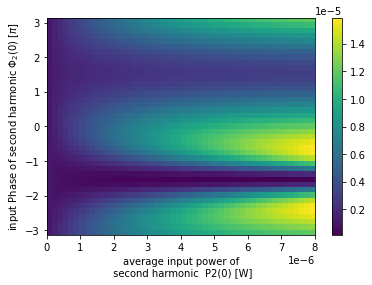

Second Harmonic


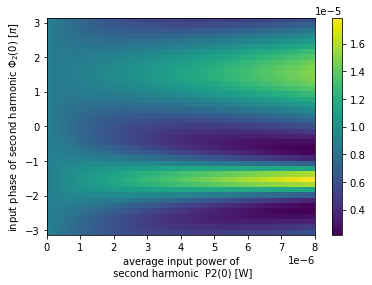

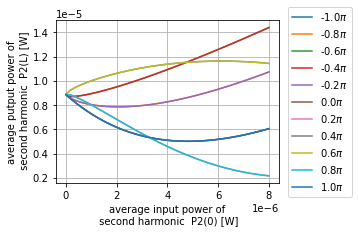

3.9999999999999996e-05
Processing Time: 10.394515037536621
Time per Iteration: 0.005070495140261766
Fundamental Mode


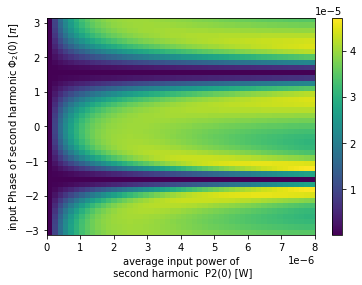

Second Harmonic


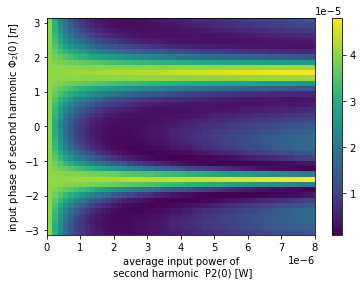

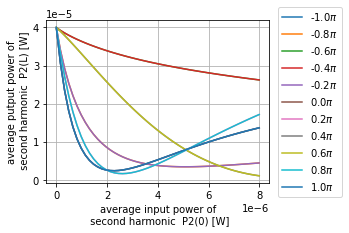

7e-05
Processing Time: 10.366664409637451
Time per Iteration: 0.00505690946811583
Fundamental Mode


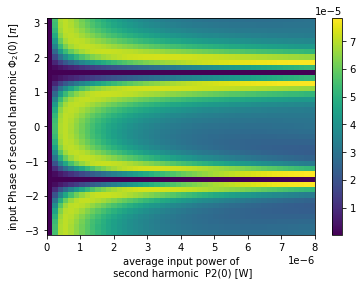

Second Harmonic


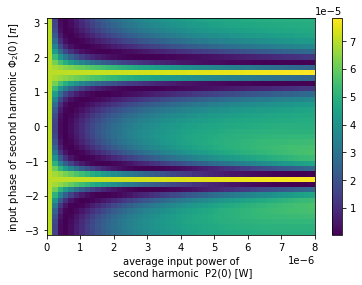

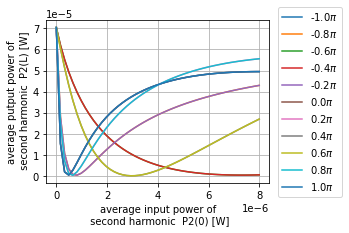

9.999999999999999e-05
Processing Time: 10.323594093322754
Time per Iteration: 0.0050358995577184165
Fundamental Mode


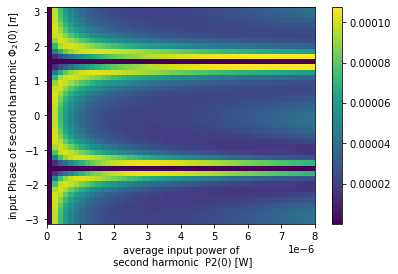

Second Harmonic


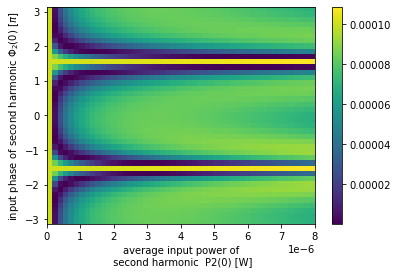

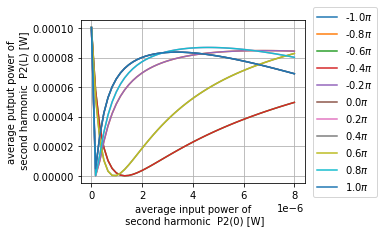

In [398]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 41
P1_avg_0_ = 1e-6
for P1_avg_0 in np.linspace(10*P1_avg_0_, 100*P1_avg_0_, 4):
    print(P1_avg_0)
    P2_avg_min, P2_avg_max = (0,8*P1_avg_0_)
    P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
    phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)

    start = time.time()
    P1 = np.zeros((nP, nPhi))
    P2 = np.zeros((nP, nPhi))
    A1 = np.zeros((nP, nPhi), dtype = np.complex128)
    A2 = np.zeros((nP, nPhi), dtype = np.complex128)
    for i,P2_avg_0 in enumerate(P2_avg_0_array):
        for j,phi2_0 in enumerate(phi2_0_array):
                L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P1_avg_0 =P1_avg_0, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0)
                A1[i,j] = A1_[-1] 
                A2[i,j] = A2_[-1]
                P1[i,j] = P1_avg_[-1] 
                P2[i,j] = P2_avg_[-1]

    end = time.time()
    print("Processing Time:", end - start)
    print("Time per Iteration:", (end - start)/(nP*nPhi))

    #Array for saved Values
    y1 = np.flip(P1.T, axis=0)
    y2 = np.flip(P2.T, axis=0)
    #Fundamental Mode
    print("Fundamental Mode")
    fig, ax = plt.subplots()
    plt.imshow(y1, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
    ax.set_ylabel("input Phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    plt.colorbar()
    plt.show()

    #Array for saved Values
    #SHG
    print("Second Harmonic")
    fig, ax = plt.subplots()
    plt.imshow(y2, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
    ax.set_ylabel("input phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    plt.colorbar()
    plt.show()

    x = P2_avg_0_array
    fig, ax = plt.subplots(figsize = (4,3))
    for k,y in enumerate(y2):
        if k%4==0:
            plt.plot(x,y, label = str(round(phi2_0_array[k]/np.pi,2)) + r"$\pi$")
    ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
    ax.set_ylabel("average putput power of\n second harmonic  P2(L) [W]")
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.grid()
    plt.show()
    

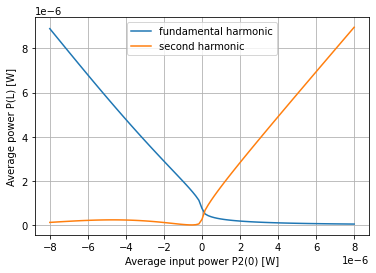

In [277]:
#Recreate that silly plot

#Reconstruct that Plot as shown in Paper
x  = np.concatenate((np.sign(phi2_0_array[-1])*np.flip(P2_avg_0_array),np.sign(phi2_0_array[1])*P2_avg_0_array))

#Amplitude
y1 = np.concatenate((np.flip(P1[:,10]),P1[:,30]))
y2 = np.concatenate((np.flip(P2[:,10]),P2[:,30]))
plt.figure()
plt.plot(x, y1 , label = "fundamental harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, y2 , label = "second harmonic") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

In [280]:
# Now I want to create a reasonable 2D plot

#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 41
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,1000*P1_avg_0)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)

start = time.time()
P1 = np.zeros((nP, nPhi))
P2 = np.zeros((nP, nPhi))
A1 = np.zeros((nP, nPhi), dtype = np.complex128)
A2 = np.zeros((nP, nPhi), dtype = np.complex128)
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = CoupledAmplitude_SHG(P1_avg_0 =P1_avg_0, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0)
            A1[i,j] = A1_[-1] 
            A2[i,j] = A2_[-1]
            P1[i,j] = P1_avg_[-1] 
            P2[i,j] = P2_avg_[-1]
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))


Processing Time: 10.189787864685059
Time per Iteration: 0.004970628226675639


Fundamental Mode


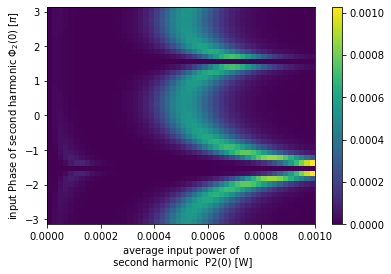

Second Harmonic


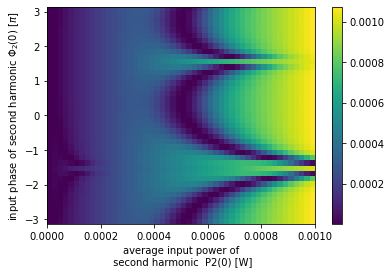

In [281]:

#Array for saved Values
y1 = np.flip(P1.T, axis=0)
y2 = np.flip(P2.T, axis=0)
#Fundamental Mode
print("Fundamental Mode")
fig, ax = plt.subplots()
plt.imshow(y1, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
ax.set_ylabel("input Phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
plt.colorbar()
plt.show()

#Array for saved Values
#SHG
print("Second Harmonic")
fig, ax = plt.subplots()
plt.imshow(y2, aspect = "auto", extent = [P2_avg_0_array.min(), P2_avg_0_array.max(),phi2_0_array.min(), phi2_0_array.max()])
ax.set_ylabel("input phase of second harmonic " + r"$\Phi_2$" + "(0)" + " [" + r"$\pi$" + "]")
ax.set_xlabel("average input power of\n second harmonic  P2(0) [W]")
plt.colorbar()
plt.show()